In [1]:
!pip install ultralytics


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from ultralytics import YOLO
import os
import boto3
import re
import cv2
import matplotlib.pyplot as plt
import shutil
import gc
import random
from sklearn.model_selection import train_test_split

In [3]:
EPOCHS=int(os.environ.get("epochs", 50))
IMGSZ=640
NB_FROZEN_LAYER=7

DATA_CONFIG_PATH = "utils/dataset.yaml"
LOCAL_DATASET_PATH = "dataset/"
LOCAL_LABEL_FOLDER = "/tmp/labels/"

DATASET_PATH = "dataset"

BASE_MODEL_PATH = "models/yolo11x.pt"
TRAIN_MODEL_PATH = f"models/new-yolo11x{NB_FROZEN_LAYER}.pt"
TRAIN_MODEL_PATH_ONNX = f"models/new-yolo11x{NB_FROZEN_LAYER}.onnx"

AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")
AWS_S3_BUCKET = os.environ.get("AWS_S3_BUCKET")
AWS_S3_ENDPOINT = os.environ.get("AWS_S3_ENDPOINT")

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [4]:
session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)
client = session.client("s3", endpoint_url=AWS_S3_ENDPOINT)

In [5]:
def download_folder(bucket_name, folder, local_dir=None):
    if local_dir is None:
        local_dir = os.getcwd()

    os.makedirs(local_dir, exist_ok = True)

    paginator = client.get_paginator('list_objects_v2')
    operation_parameters = {'Bucket': bucket_name, 'Prefix': folder}
    page_iterator = paginator.paginate(**operation_parameters)
    for page in page_iterator:
        if 'Contents' in page:
            for obj in page['Contents']:
                key = obj['Key']
                # Determine the local file path
                relative_path = os.path.relpath(key, folder)
                local_file_path = os.path.join(local_dir, relative_path)

                # Create directories if they don't exist
                os.makedirs(os.path.dirname(local_file_path), exist_ok=True)

                # Download the file
                client.download_file(bucket_name, key, local_file_path)
                print(f"Downloaded {key} to {local_file_path}")

In [6]:
def show_image(image_path, label_path):
    image = cv2.imread(image_path)
    with open(label_path, 'r') as handler:
        while True:
            line = handler.readline()
            if not line:
                break
            line = line.split(" ")
            label = int(line[0])
            x, y, w, h = (float(e) for e in line[1:])
            bbox = (float(x), float(y), float(w), float(h))
            img_h, img_w, _ = image.shape
            x1, y1, x2, y2 = x - (w / 2), y - (h / 2), x + (w / 2), y + (h / 2)
            x1, y1, x2, y2 = int(x1 * img_w), int(y1 * img_h), int(x2 * img_w), int(y2 * img_h)
            color = (0,0,255) if label == 1 else (255,0,0)
            image = cv2.rectangle(image, (x1, y1), (x2, y2), color=color, thickness=2)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        handler.close()

In [7]:
shutil.rmtree('dataset')
download_folder(AWS_S3_BUCKET, DATASET_PATH, LOCAL_DATASET_PATH)

Downloaded dataset-2/classes.txt to dataset/../dataset-2/classes.txt
Downloaded dataset-2/images/004f84d7-20240508-basketball-sj-253p-847c34.jpg to dataset/../dataset-2/images/004f84d7-20240508-basketball-sj-253p-847c34.jpg
Downloaded dataset-2/images/0205d270-crop_1.webp to dataset/../dataset-2/images/0205d270-crop_1.webp
Downloaded dataset-2/images/059bbf1e-RADS1008092300014168_01-755578235.jpg to dataset/../dataset-2/images/059bbf1e-RADS1008092300014168_01-755578235.jpg
Downloaded dataset-2/images/0c4940e2-1200x680_sig-3240176876.jpg to dataset/../dataset-2/images/0c4940e2-1200x680_sig-3240176876.jpg
Downloaded dataset-2/images/0d88904a-_110344557_1.jpg to dataset/../dataset-2/images/0d88904a-_110344557_1.jpg
Downloaded dataset-2/images/0f847ada-nbalive14_howard-3205356097.jpg to dataset/../dataset-2/images/0f847ada-nbalive14_howard-3205356097.jpg
Downloaded dataset-2/images/10a6aff1-e85296f21a9b901c76b4d4d433e9282d-1468476281.jpg to dataset/../dataset-2/images/10a6aff1-e85296f21a9b

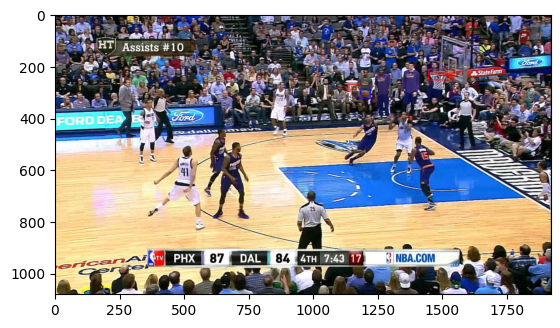

In [8]:
file = random.choice(os.listdir("dataset/images"))
file_name, file_extension = os.path.splitext(file)
label_path = f"dataset/labels/{file_name}.txt"
image_path = f"dataset/images/{file}"
show_image(image_path, label_path)

In [9]:
def split_dataset(image_dir, label_dir, output_dir, train_ratio, val_ratio, test_ratio):
    # Create output directories
    train_image_dir = os.path.join(output_dir, 'images', 'train')
    train_label_dir = os.path.join(output_dir, 'labels', 'train')
    val_image_dir = os.path.join(output_dir, 'images', 'val')
    val_label_dir = os.path.join(output_dir, 'labels', 'val')
    test_image_dir = os.path.join(output_dir, 'images', 'test')
    test_label_dir = os.path.join(output_dir, 'labels', 'test')

    os.makedirs(train_image_dir, exist_ok=True)
    os.makedirs(train_label_dir, exist_ok=True)
    os.makedirs(val_image_dir, exist_ok=True)
    os.makedirs(val_label_dir, exist_ok=True)
    os.makedirs(test_image_dir, exist_ok=True)
    os.makedirs(test_label_dir, exist_ok=True)

    # Get list of image files
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    random.shuffle(image_files)

    # Split dataset
    train_files, test_files = train_test_split(image_files, test_size=test_ratio, random_state=42)
    train_files, val_files = train_test_split(train_files, test_size=val_ratio/(train_ratio+val_ratio), random_state=42)

    # Function to move files
    def move_files(files, image_dest, label_dest):
        for file in files:
            base_name = os.path.splitext(file)[0]
            image_src = os.path.join(image_dir, file)
            label_src = os.path.join(label_dir, base_name + '.txt')

            shutil.move(image_src, os.path.join(image_dest, file))
            shutil.move(label_src, os.path.join(label_dest, base_name + '.txt'))

    # Move files to respective directories
    move_files(train_files, train_image_dir, train_label_dir)
    move_files(val_files, val_image_dir, val_label_dir)
    move_files(test_files, test_image_dir, test_label_dir)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

split_dataset(LOCAL_DATASET_PATH + 'images', LOCAL_DATASET_PATH + 'labels', LOCAL_DATASET_PATH, train_ratio, val_ratio, test_ratio)

In [10]:
client.download_file(AWS_S3_BUCKET, BASE_MODEL_PATH, "base-model.pt")

In [11]:
shutil.rmtree('runs')
gc.collect()
model = YOLO('base-model.pt')
results = model.train(data=DATA_CONFIG_PATH, epochs=EPOCHS, imgsz=IMGSZ, freeze=NB_FROZEN_LAYER, batch=-1)

Ultralytics 8.3.146 🚀 Python-3.11.9 torch-2.6.0+cu126 CUDA:0 (NVIDIA RTX A2000 12GB, 12032MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=utils/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=7, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=base-model.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrain

train: Scanning /opt/app-root/src/ai-demo/dataset/labels/train... 22 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22/22 [00:00<00:00, 1383.55it/s]

train: New cache created: /opt/app-root/src/ai-demo/dataset/labels/train.cache
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA RTX A2000 12GB) 11.75G total, 0.47G reserved, 0.47G allocated, 10.82G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


    56876086       195.5         2.584         33.55         108.3        (1, 3, 640, 640)                    list
    56876086       390.9         3.334         53.85         82.24        (2, 3, 640, 640)                    list
    56876086       781.8         4.324         86.58         95.32        (4, 3, 640, 640)                    list
    56876086        1564         6.250         171.5         151.8        (8, 3, 640, 640)                    list
    56876086        3127         9.741         336.4         275.2       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 7 for CUDA:0 6.56G/11.75G (56%) ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4274.6±1083.2 MB/s, size: 344.8 KB)


train: Scanning /opt/app-root/src/ai-demo/dataset/labels/train.cache... 22 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22/22 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1169.3±154.3 MB/s, size: 554.7 KB)


val: Scanning /opt/app-root/src/ai-demo/dataset/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 4758.14it/s]

val: New cache created: /opt/app-root/src/ai-demo/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0004921875), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       3.4G      1.412      4.064      1.528          8        640: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all          4          6      0.982      0.333      0.333      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.87G       1.32      3.946      1.283          1        640: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]

                   all          4          6      0.811      0.333      0.312      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.28G      1.205      2.594      1.165          4        640: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all          4          6      0.516      0.167     0.0146     0.0122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.53G      0.997      2.804      1.112          1        640: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

                   all          4          6      0.746        0.5      0.514      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.81G      1.024      2.037      1.018          2        640: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

                   all          4          6      0.607      0.167     0.0589     0.0243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.12G      1.095      1.983       1.13          3        640: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all          4          6      0.553      0.167     0.0294    0.00377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.37G      1.054      1.665      1.161          4        640: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all          4          6     0.0459      0.167     0.0622     0.0497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.63G      1.189      2.441      1.307          2        640: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]

                   all          4          6      0.233      0.299      0.167      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       5.9G       1.47      3.121      1.428          1        640: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]

                   all          4          6      0.326      0.434      0.335      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.87G      1.087      1.691      1.222          3        640: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all          4          6      0.484        0.5      0.336      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.04G        1.4      2.559      1.514          1        640: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all          4          6     0.0158        0.5     0.0123    0.00612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.32G     0.9763      3.183      1.034          0        640: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]

                   all          4          6          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.58G       1.01      2.059       1.21          4        640: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all          4          6          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.83G      1.017      1.825      1.218          2        640: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all          4          6     0.0272      0.167     0.0159     0.0111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       5.1G      1.039      1.425       1.13          6        640: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all          4          6   0.000912      0.333   0.000845   0.000471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.38G       1.13      1.431      1.213          2        640: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all          4          6   0.000912      0.333   0.000845   0.000471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.63G      1.111      1.237      1.322          4        640: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all          4          6    0.00451      0.333    0.00318   0.000548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.92G      1.328      1.143      1.448          3        640: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all          4          6   0.000698      0.167   0.000471   0.000141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.83G       1.13      1.729      1.471          1        640: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all          4          6   0.000698      0.167   0.000471   0.000141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.03G      1.315       1.57       1.37          3        640: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

                   all          4          6   0.000871      0.167   0.000562   5.62e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.31G      1.499      2.801      1.954          2        640: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all          4          6   0.000871      0.167   0.000562   5.62e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.57G      1.219      1.796       1.33          5        640: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all          4          6   0.000417      0.167   0.000289   2.89e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.85G      1.091       1.74      1.397          2        640: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all          4          6   0.000417      0.167   0.000289   2.89e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.12G      1.175      3.288      1.439          1        640: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all          4          6          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.38G      1.334      1.705      1.471          4        640: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all          4          6          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.65G       1.32      2.264      1.655          2        640: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all          4          6          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       5.9G      1.389      1.941      1.766          1        640: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all          4          6          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.86G      1.158      1.141      1.335          2        640: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all          4          6          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.05G      1.251      1.341      1.371          6        640: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all          4          6          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.31G      1.029      1.172       1.27          1        640: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

                   all          4          6          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.59G      1.635      1.861      1.394          1        640: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all          4          6          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.85G      1.112      1.319       1.62          2        640: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all          4          6          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.12G      1.046      1.204      1.446          2        640: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all          4          6      0.501      0.167   0.000317   0.000286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.38G      1.515      1.388      1.617          2        640: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

                   all          4          6      0.501      0.167   0.000317   0.000286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.65G     0.9528      1.415      1.283          1        640: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all          4          6      0.501      0.167   0.000317   0.000286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       5.9G       1.36      1.368      1.723          1        640: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all          4          6   0.000563      0.167   0.000334   0.000268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.87G     0.8504     0.9048      1.227          4        640: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all          4          6   0.000563      0.167   0.000334   0.000268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.05G     0.8673     0.7626      1.155          3        640: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all          4          6   0.000698      0.167   0.000409   0.000327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.31G     0.8863     0.7597      1.122          5        640: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

                   all          4          6   0.000698      0.167   0.000409   0.000327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.57G      0.987     0.8336      1.185          2        640: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all          4          6     0.0372        0.5     0.0158      0.014


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.85G     0.8167     0.7316     0.9833          1        640: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all          4          6     0.0372        0.5     0.0158      0.014



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.12G     0.7836     0.7858       1.07          2        640: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all          4          6      0.425        0.5       0.18      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       5.4G     0.7899     0.8801      1.161          1        640: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all          4          6      0.425        0.5       0.18      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.67G     0.7506     0.9871      1.235          1        640: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all          4          6      0.425        0.5       0.18      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       5.9G     0.6234     0.6583      1.029          1        640: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all          4          6      0.863        0.5      0.518      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.85G     0.6884     0.7817      1.172          1        640: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all          4          6      0.863        0.5      0.518      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.05G     0.7542     0.7692      1.089          2        640: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all          4          6      0.805        0.5      0.556      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.31G     0.7072     0.7461      1.073          1        640: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all          4          6      0.805        0.5      0.556      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.57G     0.6868     0.6492      1.073          1        640: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all          4          6      0.804        0.5      0.567      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.85G     0.6159     0.5685     0.9625          1        640: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all          4          6      0.804        0.5      0.567      0.375



50 epochs completed in 0.073 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 114.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.9 torch-2.6.0+cu126 CUDA:0 (NVIDIA RTX A2000 12GB, 12032MiB)
YOLO11x summary (fused): 190 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


                   all          4          6      0.862        0.5      0.519      0.393
                  Ball          3          3      0.779      0.667      0.665      0.499
                  Hoop          3          3      0.946      0.333      0.373      0.287
Speed: 0.2ms preprocess, 24.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train


In [12]:
model = YOLO('runs/detect/train/weights/best.pt')

In [13]:
model.export(format="onnx")

Ultralytics 8.3.146 🚀 Python-3.11.9 torch-2.6.0+cu126 CPU (Intel Core(TM) i7-14700F)
YOLO11x summary (fused): 190 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (109.1 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 8.1s, saved as 'runs/detect/train/weights/best.onnx' (217.1 MB)

Export complete (15.5s)
Results saved to /opt/app-root/src/ai-demo/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.onnx imgsz=640 data=utils/dataset.yaml  
Visualize:       https://netron.app


'runs/detect/train/weights/best.onnx'

In [14]:
model_path = "runs/detect/train/weights/best.onnx"

In [15]:
client.upload_file(model_path, AWS_S3_BUCKET, TRAIN_MODEL_PATH_ONNX)

In [16]:
client.upload_file('runs/detect/train/weights/best.pt', AWS_S3_BUCKET, TRAIN_MODEL_PATH)

In [17]:
client.upload_file('runs/detect/train/results.csv', AWS_S3_BUCKET, 'results.csv')